In [ ]:
!pip install hdf5storage

In [1]:
import scipy, os, hdf5storage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


#### Explore the raw data, plot a sample FFT graph (pick one 300 mb file from here)

In [2]:
file_address = os.path.join(
    'sample', 'StrainRate_85-165meters_StartTime_2023-12-19_14-50-37.mat'
    )

mat = hdf5storage.loadmat(file_address)

In [3]:
# data seems to be located at StrainRate:

subsystem = mat['#subsystem#'][0][0][0]
DASsettings = mat['DASsettings'][0]
StrainRate = mat['StrainRate'][0]

In [4]:
# My guest on data structure:

data2 = StrainRate[2][0][0]; #dim: (101, 900000) seems 101 recorded data (at each timestep) by each sensor in wide formate

data5 = StrainRate[5][0]; # dim: (900000,) # seems timestamp

data1 = StrainRate[1][0]; # dim: (6,) # unknown maybe some metadata
data6 = StrainRate[6][0]; # dim: (6,) # unknown maybe some metadata

label = StrainRate[4][0][0][0][0]; # just an unknown label (seems FEA related)

data3 = np.squeeze(StrainRate[3][0][0]); # dim: (101,) # seems a value or label for each sensor

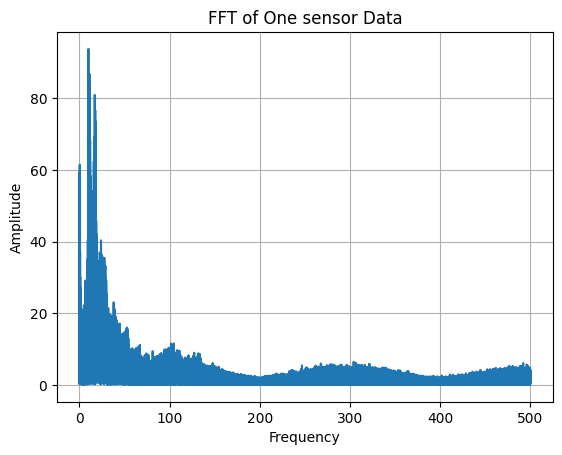

In [5]:
# Working on 1 sensor data:
# Assuming 'data2' the sensor data and 'data5' is the timestamp data.

# Selecting data from one sensor for FFT analysis
sensor_data = data2[0]

# Number of data points (assumed the length of the timestamp)
N = len(data5)

T = data5[1] - data5[0]

yf = scipy.fft.fft(sensor_data)
xf = scipy.fft.fftfreq(N, T)[:N//2]

plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.title('FFT of One sensor Data')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


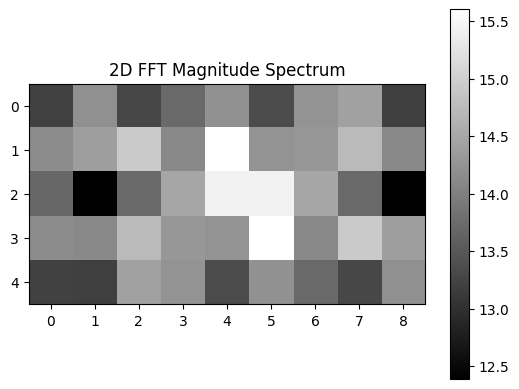

In [6]:
# Working on multiple sensor data:
# As I am not familiar with 2d FFT, I stay with 1D for now.

image = data2[:5]

fft_result = np.fft.fft2(image)

magnitude_spectrum = np.abs(np.fft.fftshift(fft_result))[:,::100000]

plt.imshow(np.log1p(magnitude_spectrum), cmap='gray')
plt.colorbar()
plt.title('2D FFT Magnitude Spectrum')
plt.show()


#### Create a python function that takes as an input a path to the raw data file and gives on the output a pandas.DataFrame with 3 columns: timestamp, label, value (The raw data might contain the data for multiple sensors in a "wide" format; convert it to "narrow").

In [7]:
def transform_to_dataframe(file_address):
    """
    Assumption:
    - data2 is the wide sensor data
    - data3 is sensors' labels
    - data5 is the timestamp

    Arg:
    file_address

    Returns:
    DataFrame with columns 'timestamp', 'label', and 'value'.
    """

    mat = hdf5storage.loadmat(file_address)
    StrainRate = mat['StrainRate'][0]
    data2 = StrainRate[2][0][0]
    data5 = StrainRate[5][0]
    data3 = np.squeeze(StrainRate[3][0][0])

    
    num_sensors, num_timestamps = data2.shape
    narrow_data = data2.reshape(-1)

    repeated_timestamps = np.tile(data5, num_sensors)
    repeated_labels = np.repeat(data3, num_timestamps)

    # Create the DataFrame
    df = pd.DataFrame({
        'timestamp': repeated_timestamps,
        'label': repeated_labels,
        'value': narrow_data
    })

    return df

In [10]:
dataframe = transform_to_dataframe(file_address)
dataframe.head()

,timestamp,label,value
0,0.000,85.6,471.708008
1,0.001,85.6,207.158066
2,0.002,85.6,-641.408508
3,0.003,85.6,-550.619385
4,0.004,85.6,1407.755859


#### Create a python function that takes the data produced by the function above and computes the dominating frequencies. The suggested approach is to compute the FFT and select n peaks, where n can be also an input argument. Mind that there are multiple sensors, so we might need to consider a 2d FFT.

In [11]:
def get_dominating_frequencies(df, n_peaks=3):
    """
    Assuption:
    This is implemented by 1D FFT, can be later updated to 2D FFT
    
    Args:
    df: Data containing 'timestamp', 'label', and 'value' columns.
    n_peaks: Number of dominating frequencies to identify.

    Returns:
    DataFrame containing dominating frequencies for each sensor.
    """
    all_sensor_dfs = pd.DataFrame()

    for label, group in df.groupby('label'):
        group = group.sort_values(by='timestamp') # sort timestaps just to be more careful
        
        N = group.shape[0] # Number of data points
        T = group['timestamp'].iloc[1] - group['timestamp'].iloc[0]

        yf = scipy.fft.fft(group['value'].values)

        # taking only the positive frequency components (as they take all information)
        xf = scipy.fft.fftfreq(N, T)[:N//2] 

        peaks, _ = scipy.signal.find_peaks(np.abs(yf[:N//2]), height=0)

        top_peaks = peaks[np.argsort(np.abs(yf[peaks]))[:int(n_peaks)]]
        top_frequencies = xf[top_peaks]
        
        sensor_df = pd.DataFrame({'label': label, 'frequency': top_frequencies})

        all_sensor_dfs = pd.concat([all_sensor_dfs, sensor_df])

    return all_sensor_dfs

In [12]:
frequencies_df = get_dominating_frequencies(dataframe, n_peaks=5)
frequencies_df.head(100)

,label,frequency
0,85.6,201.627778
1,85.6,386.124444
2,85.6,210.238889
3,85.6,396.020000
4,85.6,391.616667
...,...,...
0,100.8,393.792222
1,100.8,411.587778
2,100.8,172.690000
3,100.8,408.044444
